# Load names.txt file

In [3]:
words = open('../names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [122]:
len(words)

32033

# Mapping chards to unique ids

In [123]:
chars = sorted(set(''.join(words)))
ch2i = {ch: i + 1 for i, ch in enumerate(chars)}
ch2i['.'] = 0
i2ch = {i: ch for ch, i in ch2i.items()}
i2ch

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

# Creating dataset

In [124]:
import torch
import random

sequence_size = 3
X, y = [], []

random.shuffle(words)
for w in words:
    # Start context ['.', '.', ch0]
    context = [0] * (sequence_size - 1) + [ch2i[w[0]]]
    for ch in w[1:] + '.':
        ch_id = ch2i[ch]
        X.append(context)
        y.append(ch_id)
        context = context[1:] + [ch_id]

X = torch.tensor(X)
y = torch.tensor(y)

In [125]:
print(X.shape)
print(y.shape)

torch.Size([196113, 3])
torch.Size([196113])


In [126]:
print(X[:4])

tensor([[ 0,  0,  3],
        [ 0,  3,  1],
        [ 3,  1, 20],
        [ 1, 20,  5]])


In [127]:
print(y[:4])

tensor([ 1, 20,  5, 18])


# Splitting Dataset into Train, validation and Test Set

In [128]:
split1 = int(0.8 * X.shape[0])
split2 = int(0.9 * X.shape[0])

X_train, y_train = X[:split1], y[:split1]
X_valid, y_valid = X[split1:split2], y[split1:split2]
X_test, y_test = X[split2:], y[split2:]

In [129]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

torch.Size([156890, 3]) torch.Size([156890])
torch.Size([19611, 3]) torch.Size([19611])
torch.Size([19612, 3]) torch.Size([19612])


# Model

## Defining Model's Parameters

In [216]:
n_chars = len(ch2i)
n_emb_features = 10
n_inputs_W1 = sequence_size * n_emb_features
W1_size = 200
W2_size = 100
W3_size = len(ch2i)


C = torch.randn((n_chars, n_emb_features))
W1 = torch.randn((n_inputs_W1, W1_size))
b1 = torch.randn(W1_size)
W2 = torch.randn((W1_size, W2_size))
b2 = torch.randn(W2_size)
W3 = torch.randn((W2_size, W3_size))
b3 = torch.randn(W3_size)

parameters = [C, W1, b1, W2, b2, W3, b3]
for p in parameters:
    p.requires_grad = True

In [203]:
sum(p.nelement() for p in parameters)

29297

## Choosing Learning Rate

In [204]:
lre = torch.linspace(-3, 1, 1000)
lrs = 10 ** lre  # lrs <0.001, 1.0>

In [205]:
import torch.nn.functional as F

batch_size = 32
lri = []
lossi = []

for i in range(lrs.shape[0]):
    batch_ids = torch.randint(0, X_train.shape[0], (batch_size,))

    # Forward Pass
    emb = C[X_train[batch_ids]]
    h1 = torch.tanh(emb.view(batch_size, -1) @ W1 + b1)
    h2 = torch.tanh(h1 @ W2 + b2)
    logits = h2 @ W3 + b3
    loss = F.cross_entropy(logits, y_train[batch_ids])

    # Reset Grad
    for p in parameters:
        p.grad = None
    
    # Backward pass
    loss.backward()
    for p in parameters:
        p.data += -lrs[i] * p.grad

    lri.append(lre[i])
    lossi.append(loss.item())

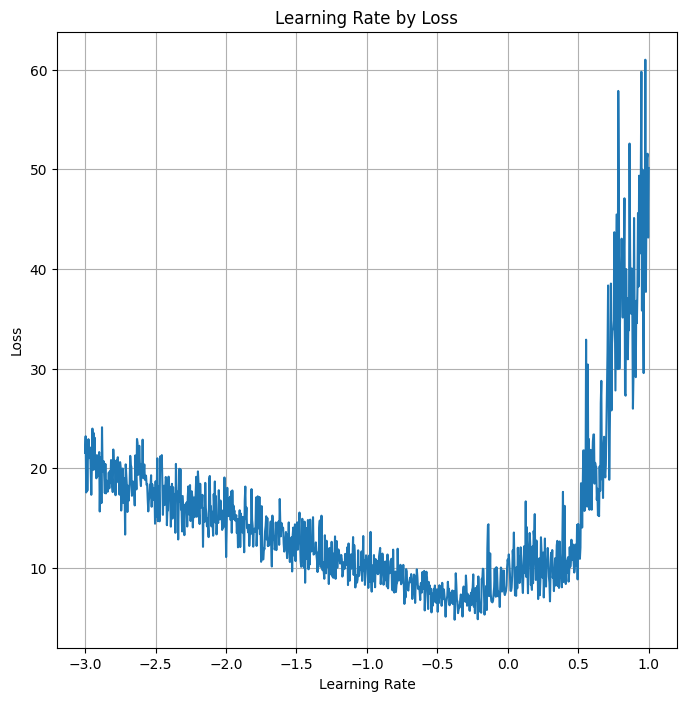

In [206]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.plot(lri, lossi)

plt.title('Learning Rate by Loss')
plt.ylabel('Loss')
plt.xlabel('Learning Rate')
plt.grid()
plt.show()

## Training Model

In [282]:
n_chars = len(ch2i)
n_emb_features = 10
n_inputs_W1 = sequence_size * n_emb_features
W1_size = 200
W2_size = 100
W3_size = len(ch2i)


C = torch.randn((n_chars, n_emb_features))
W1 = torch.randn((n_inputs_W1, W1_size))
b1 = torch.randn(W1_size)
W2 = torch.randn((W1_size, W2_size))
b2 = torch.randn(W2_size)
W3 = torch.randn((W2_size, W3_size))
b3 = torch.randn(W3_size)

parameters = [C, W1, b1, W2, b2, W3, b3]
for p in parameters:
    p.requires_grad = True

In [283]:
lossi = []
stepi = []

In [284]:
n_epochs = 300000
batch_size = 32
lr = 0.1

for i in range(n_epochs):
    batch_ids = torch.randint(0, X_train.shape[0], (batch_size,))

    # Forward Pass
    emb = C[X_train[batch_ids]]
    h1 = torch.tanh(emb.view(batch_size, -1) @ W1 + b1)
    h2 = torch.tanh(h1 @ W2 + b2)
    logits = h2 @ W3 + b3
    loss = F.cross_entropy(logits, y_train[batch_ids])
    lossi.append(loss.item())
    stepi.append(i)

    # Reset Grad
    for p in parameters:
        p.grad = None 

    # Backward Pass
    loss.backward()
    learning_rate = lr if i < 100000 else lr * 0.1 if i < 200000 else lr * 0.05
    for p in parameters:
        p.data += -learning_rate * p.grad

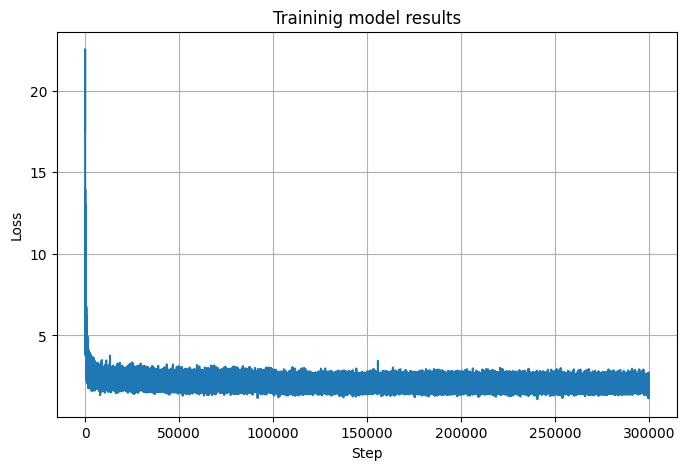

In [309]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(stepi, lossi)

plt.title('Traininig model results')
plt.ylabel('Loss')
plt.xlabel('Step')
plt.grid()
plt.show()

## Evaluate Model on Valdiation set

In [311]:
emb = C[X_valid]
h1 = torch.tanh(emb.view(X_valid.shape[0], -1) @ W1 + b1)
h2 = torch.tanh(h1 @ W2 + b2)
logits = h2 @ W3 + b3
loss = F.cross_entropy(logits, y_valid)
print(loss)

tensor(2.0623, grad_fn=<NllLossBackward0>)


# Model Inference

In [323]:
for _ in range(20):
    out = []
    
    first_char = torch.randint(1, len(ch2i), (1,)).item()
    sequence = [0] * (sequence_size - 1) + [first_char]
    out.extend(sequence[1:])
    while True:
        emb = C[sequence]
        h1 = torch.tanh(emb.view(1, -1) @ W1 + b1)
        h2 = torch.tanh(h1 @ W2 + b2)
        logits = h2 @ W3 + b3
        probs = F.softmax(logits)

        next_char_id = torch.multinomial(probs, num_samples=1).item()
        out.append(next_char_id)
        sequence = sequence[1:] + [next_char_id]

        if next_char_id == 0:
            break
    
    print(''.join(i2ch[ch_id] for ch_id in out))

.daeslei.
.zalindny.
.daea.
.arrion.
.marlynn.
.favannitli.
.monniri.
.thyn.
.yan.
.wilee.
.elinn.
.dola.
.ukmiaul.
.wectorianna.
.evereckleksuura.
.vie.
.wamhel.
.kasumah.
.elyjmara.
.olanah.


/tmp/ipykernel_7638/43390724.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits)


# Exercise
E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

In [279]:
n_chars = len(ch2i)
n_emb_features = 10
n_inputs_W1 = sequence_size * n_emb_features
W1_size = 200
W2_size = 100
W3_size = len(ch2i)


C = torch.randn((n_chars, n_emb_features))
W1 = torch.randn((n_inputs_W1, W1_size)) * 0.01
b1 = torch.zeros(W1_size)
W2 = torch.randn((W1_size, W2_size)) * 0.01
b2 = torch.zeros(W2_size)
W3 = torch.randn((W2_size, W3_size)) * 0.01
b3 = torch.zeros(W3_size)

parameters = [C, W1, b1, W2, b2, W3, b3]
for p in parameters:
    p.requires_grad = True

In [280]:
n_epochs = 100
batch_size = 32
lr = 0.1

lossi = []
stepi = []
for i in range(n_epochs):
    batch_ids = torch.randint(0, X_train.shape[0], (batch_size,))

    # Forward Pass
    emb = C[X_train[batch_ids]]
    h1 = torch.tanh(emb.view(batch_size, -1) @ W1 + b1)
    h2 = torch.tanh(h1 @ W2 + b2)
    logits = h2 @ W3 + b3
    loss = F.cross_entropy(logits, y_train[batch_ids])
    lossi.append(loss.item())
    stepi.append(i)

    # Reset Grad
    for p in parameters:
        p.grad = None 

    # Backward Pass
    loss.backward()
    learning_rate = lr
    for p in parameters:
        p.data += -learning_rate * p.grad

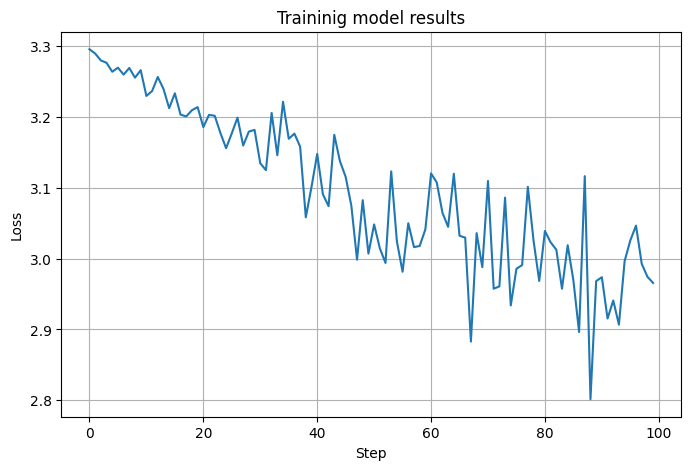

In [281]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(stepi, lossi)

plt.title('Traininig model results')
plt.ylabel('Loss')
plt.xlabel('Step')
plt.grid()
plt.show()